# Bayesian Inference in Practice: Mock Data Sample

In this notebook we will carry out a complete data science project using a mock data sample: Boston Housing data sample. Cliche and frowned upon to use these types of datasets, this notebook is a first attempt at demonstrating understanding of the concepts associated with Bayesian inference.

Some of the code and notes were taken from William Koehrsen's Jupyter notebook on Bayesian inference, which you can find [here](https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb).

In [ ]:
# Imports
# The usual suspects ...
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Distributions
import scipy as sp

# Scipy helper functions
from scipy.stats import percentileofscore
from scipy import stats

# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.datasets import load_boston

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Warning
from warnings import filterwarnings

# Settings
filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

In [2]:
# Loading the data
boston = load_boston()
df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2

##### Notes
Characteristics:
>- **Number of Instances:** 506
>- **Number of Attributes:** 13
>- Median Value (variable 14) is usually the target.

Variables:
>1. **CRIM** - per capita crime rate by town.
>2. **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft.
>3. **INDUS** - proportion of non-retail business acres per town.
>4. **CHAS** - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
>5. **NOX** - nitric oxides concentration (parts per 10 million).
>6. **RM** - average number of rooms per dwelling.
>7. **AGE** - proportion of owner-occupied units built prior to 1940.
>8. **DIS** - weighted distances to five Boston employment centres.
>9. **RAD** - index of accessibility to radial highways.
>10. **TAX** - full-value property-tax rate per USD10,000.
>11. **PTRATIO** - pupil-teacher ratio by town.
>12. **B** - $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town.
>13. **LSTAT** - % lower status of the population.
>14. **MEDV** - Median value of owner-occupied homes in USD1000's.

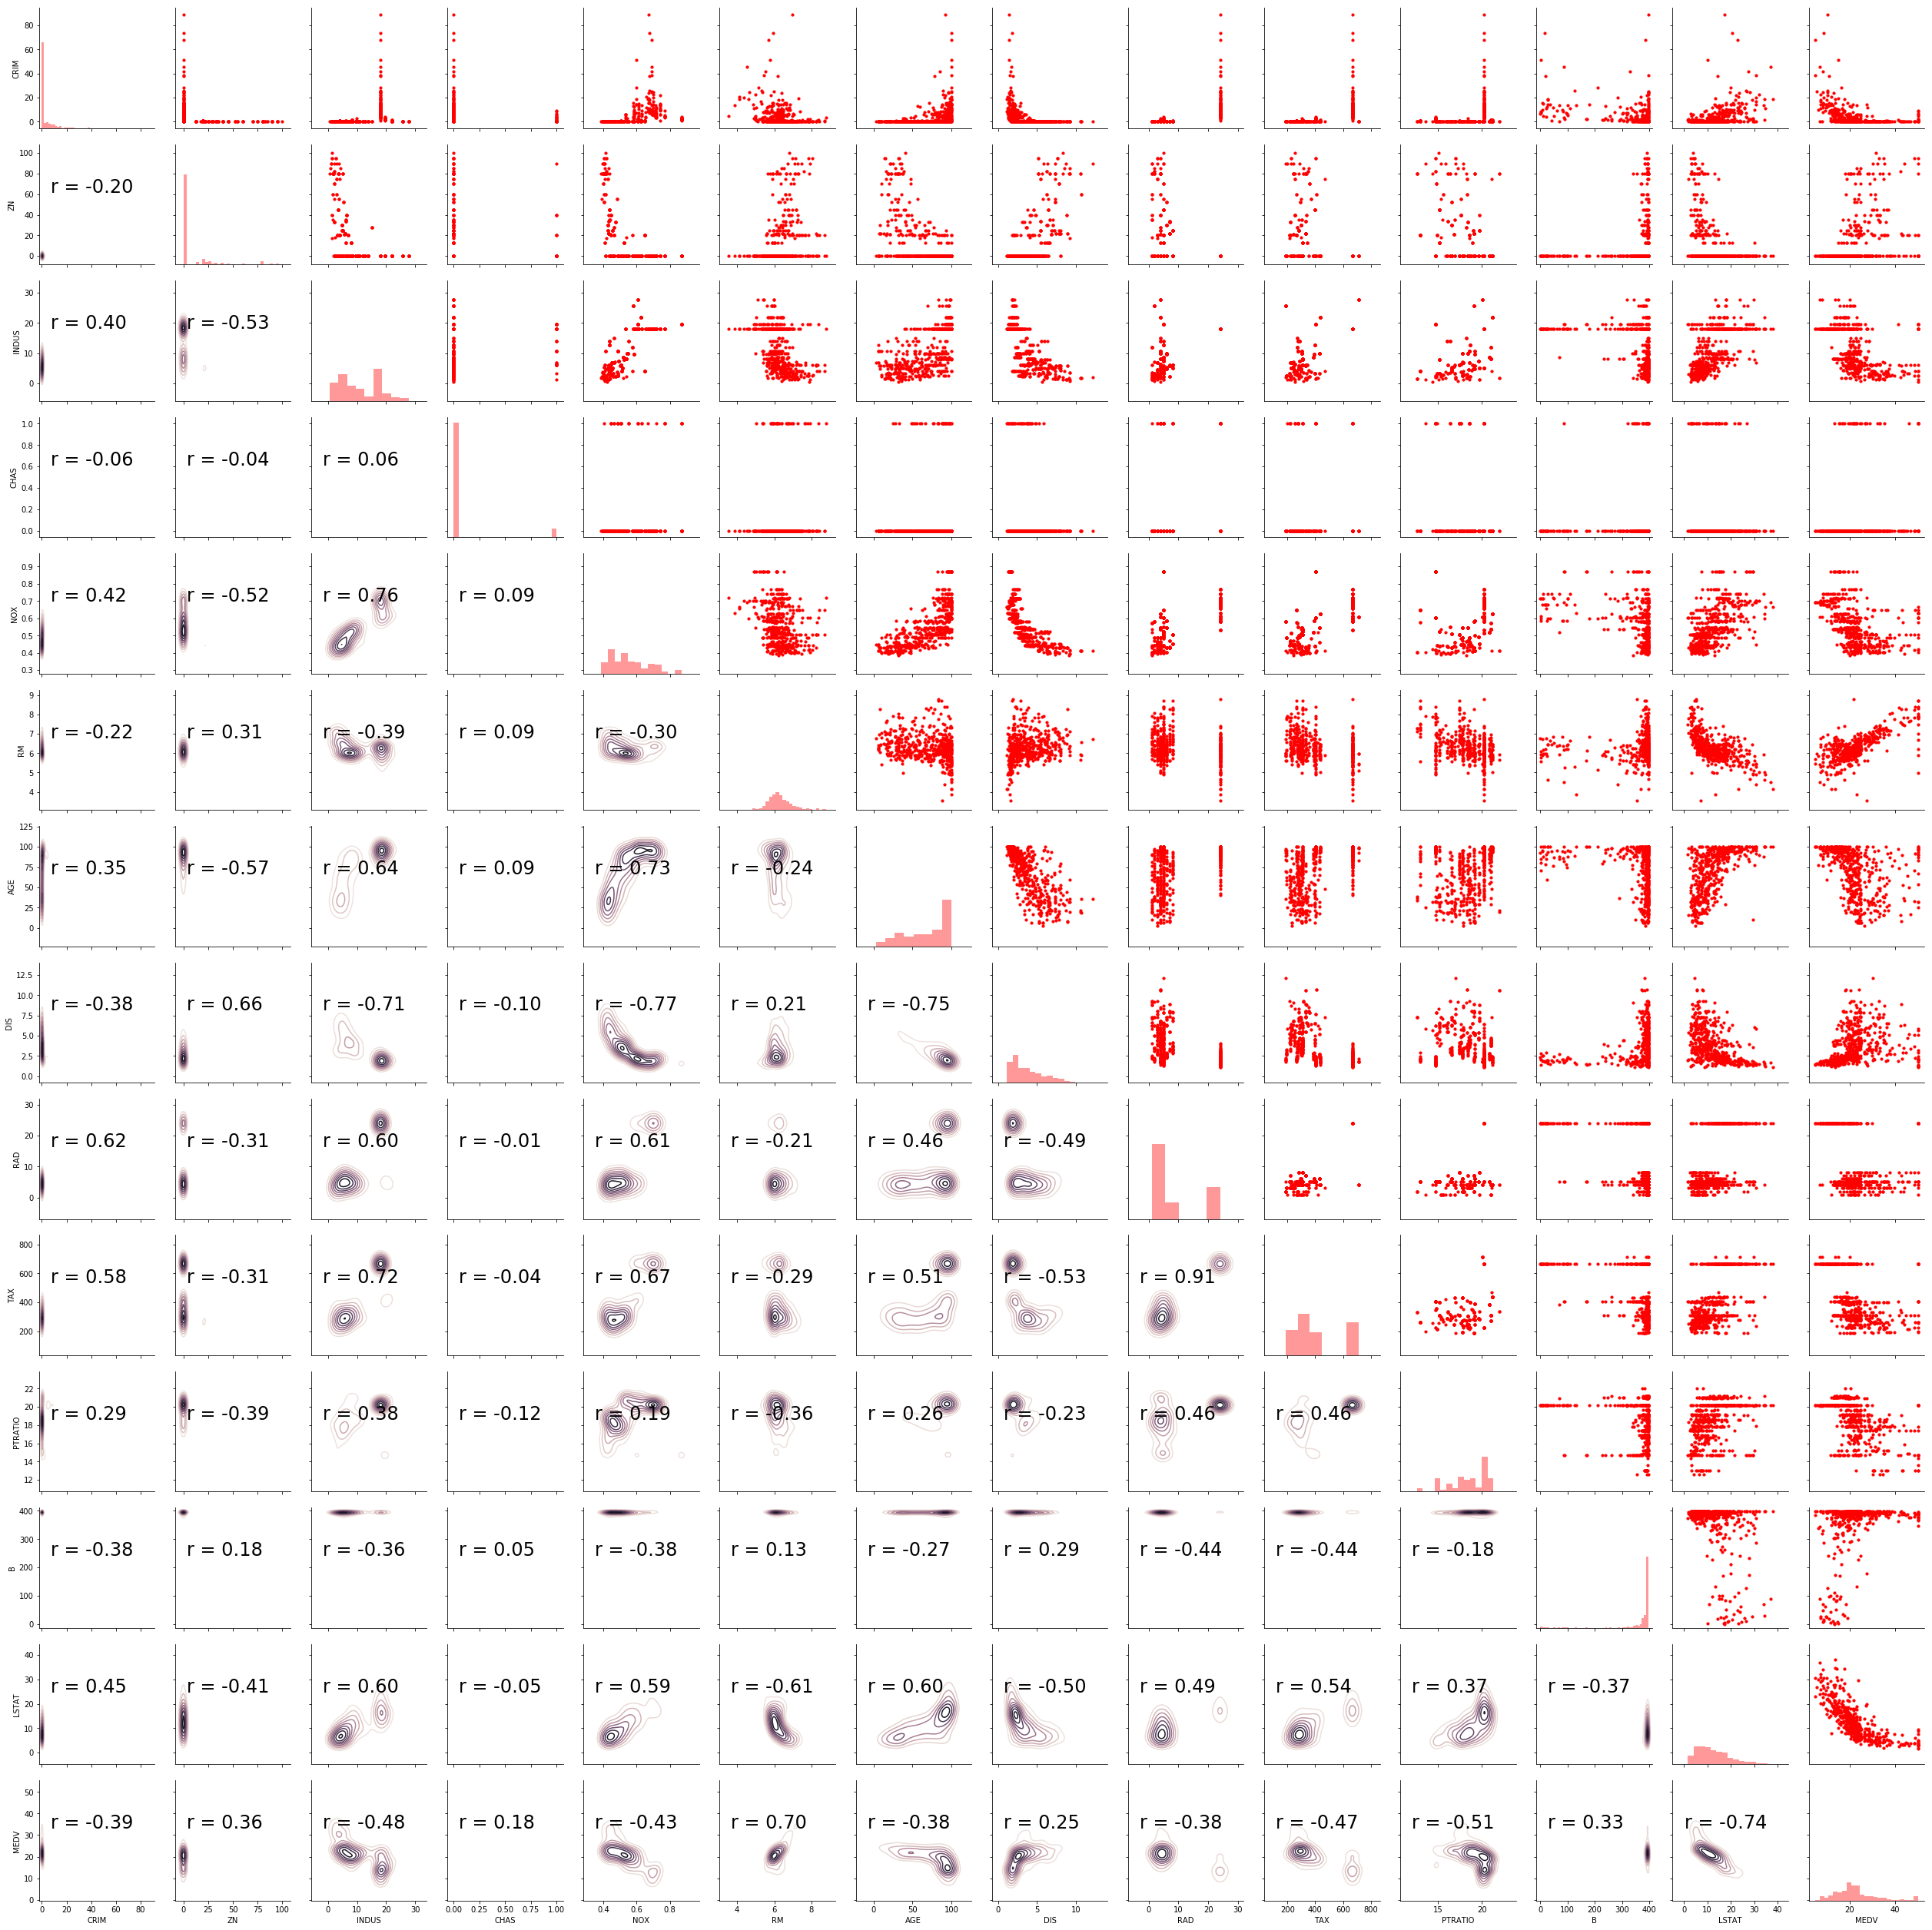

In [3]:
# Calculate correlation coefficients
def corrfunc(x, y, **kws):
    '''Calculate correlation coefficients.'''
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [4]:
# Create relation to the target column
df_plot = df.copy()
df_plot['relation_median'] = (df_plot['MEDV'] >= df_plot['MEDV'].median())
df_plot['relation_median'] = df_plot['relation_median'].replace({True: 'above', False: 'below'})
df_plot = df_plot.drop(columns='MEDV')

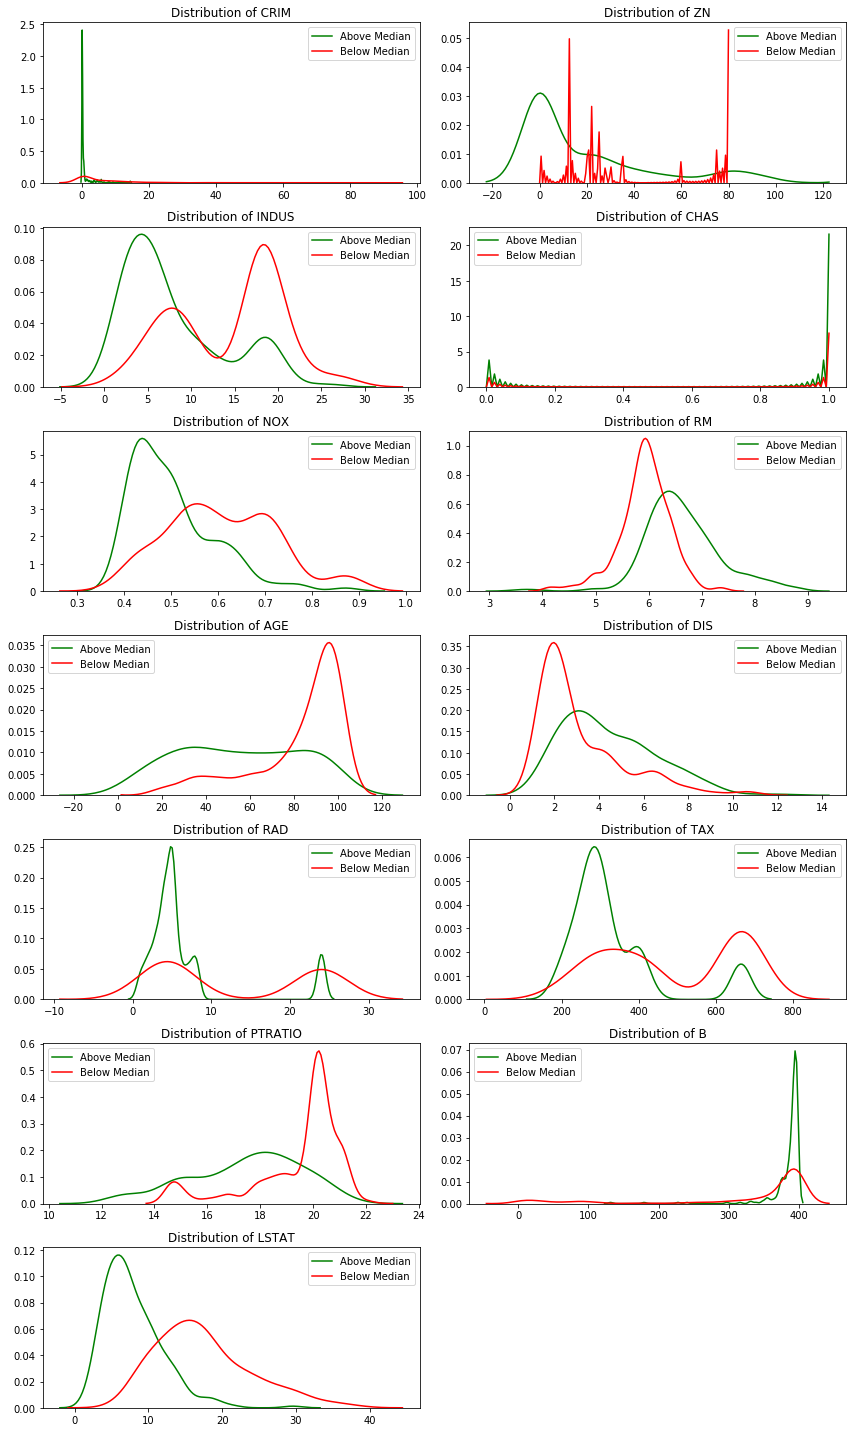

In [5]:
plt.figure(figsize=(12, 20))
# Plot the distribution of each variable colored
# by the relation to the mean property tax
for i, col in enumerate(df_plot.columns[:-1]):
    plt.subplot(7, 2, i + 1)
    subset_above = df_plot[df_plot['relation_median'] == 'above']
    subset_below = df_plot[df_plot['relation_median'] == 'below']
    sns.kdeplot(subset_above[col], label = 'Above Median', color = 'green')
    sns.kdeplot(subset_below[col], label = 'Below Median', color = 'red')
    plt.legend(); plt.title('Distribution of %s' % col)

plt.tight_layout()

#### Metrics

This is a regression task and we will use two metrics:

>- Mean Absolute Error (MAE): Average of the absolute value of the difference between predictions and the true values.
>- Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and the true values.

The MAE is more interpretable, while the RMSE penalizes larger errors more heavily.

In [6]:
# Metrics
def evaluate_predictions(predictions, true):
    '''Calculates the Mean Absolute Error (MAE) & Root Mean Squared Error (RMSE)'''
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    return mae, rmse

#### Naive Baseline

For a regression task, a simple naive baseline is to guess the median value on the training set for all testing cases. If our machine learning model cannot better this simple baseline, then we may need to try a different approach.

In [7]:
# Splitting the data
def format_data(df):
    # Target
    labels = df['MEDV']
    
    # Correlations with 'MEDV'
    most_correlated = df.corr().abs()['MEDV'].sort_values(ascending=False)
    
    # Maintain top 6 features that are highly correlated with 'MEDV'
    most_correlated = most_correlated[:7]
    df = df.loc[:, most_correlated.index]
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=.25, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = format_data(df)

In [8]:
# Naive baseline
median_pred = X_train['MEDV'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['MEDV']

In [9]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 5.9276
Median Baseline RMSE: 8.3731


#### Standard Machine Learning Models

We'll train and test several machine learning models for comparison with the Bayesian inference model.

In [10]:
# Evaluate machine learning models
def evaluate(X_train, X_test, y_train, y_test):
    '''Evaluate the machine learning models for comparison.'''
    # Model names
    model_name_list = ['Linear Regression',
                       'ElasticNet Regression',
                       'Random Forest',
                       'Extra Trees',
                       'SVM',
                       'Gradient Boosted',
                       'Baseline']
    X_train = X_train.drop('MEDV', axis=1)
    X_test = X_test.drop('MEDV', axis=1)
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1., l1_ratio=.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1., gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index=model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Inserting results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

results = evaluate(X_train, X_test, y_train, y_test)

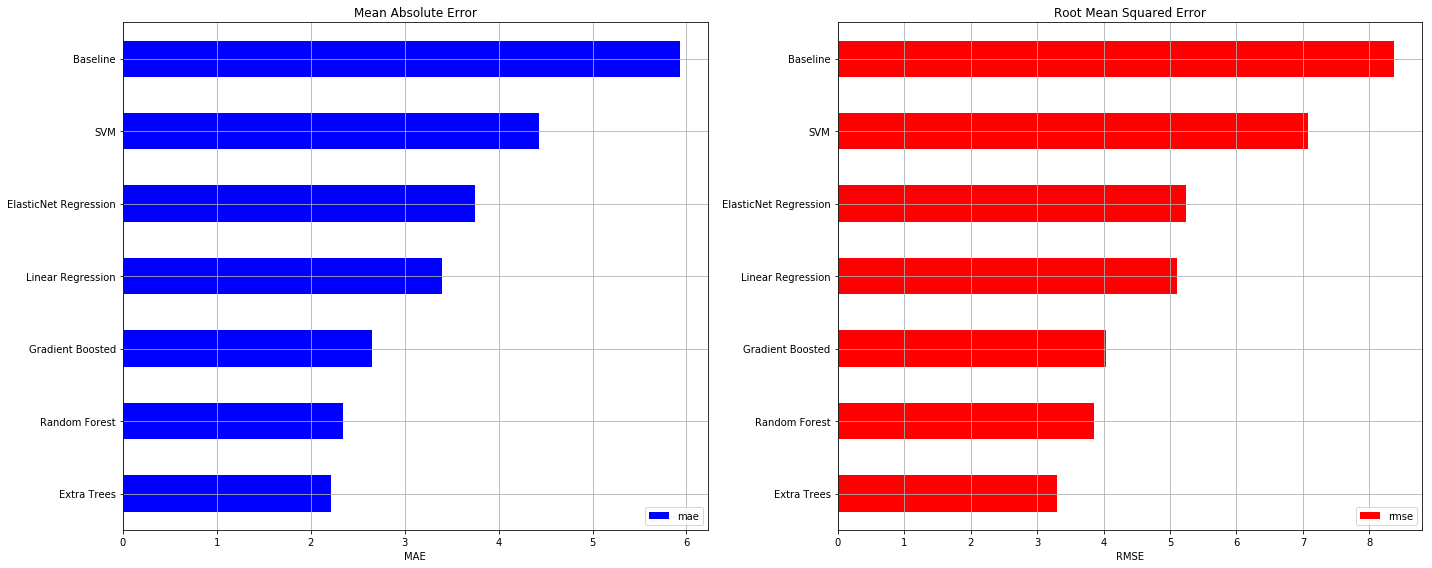

In [11]:
# Visualize results
# RMSE
plt.figure(figsize=(20,8), edgecolor='black')
ax = plt.subplot(1, 2, 1)
results.sort_values('mae', ascending=True).plot.barh(y='mae', color='b', ax=ax)
plt.title('Mean Absolute Error')
plt.xlabel('MAE')
plt.grid()

# MAE
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending=True).plot.barh(y='rmse', color='r', ax=ax)
plt.title('Root Mean Squared Error')
plt.xlabel('RMSE')
plt.grid()

plt.tight_layout()

In [12]:
print('The Gradient Boosted regressor is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Gradient Boosted', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Support Vector Machine is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['SVM', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Extra Trees are {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Extra Trees', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The Random Forest is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Random Forest', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The ElasticNet Regression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['ElasticNet Regression', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))
print('The LinearRegression is {:0.2f}% better than the baseline.'.format(
    (100 * abs(results.loc['Linear Regression', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Gradient Boosted regressor is 55.32% better than the baseline.
The Support Vector Machine is 25.32% better than the baseline.
The Extra Trees are 62.55% better than the baseline.
The Random Forest is 60.52% better than the baseline.
The ElasticNet Regression is 36.68% better than the baseline.
The LinearRegression is 42.71% better than the baseline.


#### Ordinary Least Squares (OLS) Regression

In [13]:
# OLS formula
lr = LinearRegression()
lr.fit(X_train.drop('MEDV', axis=1), y_train)
ols_formula = 'MEDV = %.2f +' % lr.intercept_
for i, col in enumerate(X_train.drop('MEDV', axis=1).columns):
    ols_formula += ' %.2f * %s +' % (lr.coef_[i], col)
' '.join(ols_formula.split(' ')[:-1])

'MEDV = 15.57 + -0.57 * LSTAT + 4.96 * RM + -0.82 * PTRATIO + 0.12 * INDUS + -0.00 * TAX + -2.84 * NOX'

#### Implementing Bayesian Linear Regression

In [14]:
# Formula for Bayesian Linear Regression
formula = 'MEDV ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'MEDV ~ LSTAT + RM + PTRATIO + INDUS + TAX + NOX'

#### Create Model in PyMC3 and Sample from Posterior

We now build the model using the formula defined above and a Normal distribution for the data likelihood. Then, we let a Markov Chain Monte Carlo algorithm draw samples from the posterior to approximate the posterior for each of the model parameters.

In [15]:
# Context for the model
with pm.Model() as normal_model:
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula=formula, data=X_train, family=family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains=2, tune=1000, njobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, NOX, TAX, INDUS, PTRATIO, RM, LSTAT, Intercept]
100%|██████████| 3000/3000 [00:40<00:00, 74.53it/s]


#### Examining Bayesian Linear Regression Results

##### Traceplots of All Samples

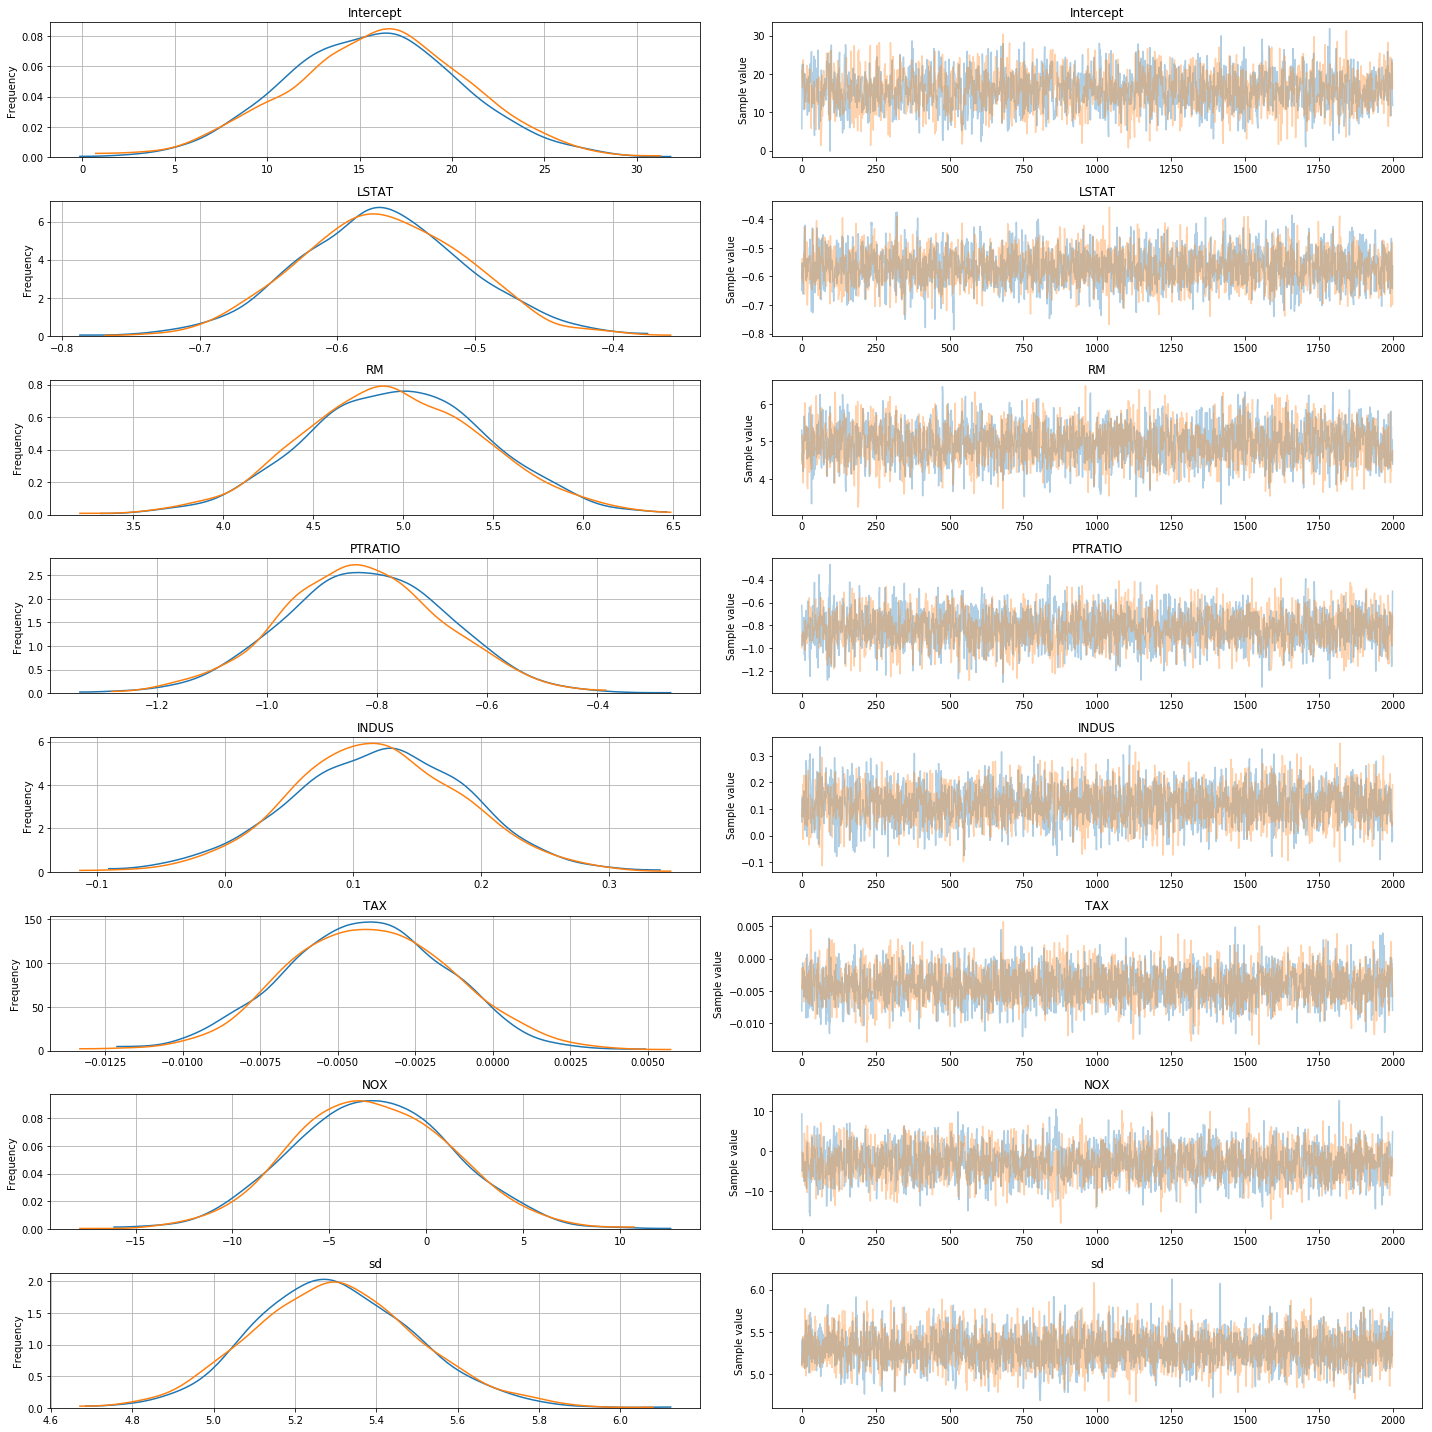

In [16]:
# Trace plot
pm.traceplot(normal_trace, figsize=(20, 20), grid=True)
plt.tight_layout()

The left side of the traceplot is the marginal posterior: the values for the variable are on the x-axis with the probability for the variable (as determined by sampling) on the y-axis. The different colored lines indicate that we performed two chains of Markov Chain Monte Carlo. From the left side we can see that there is a range of values for each weight. The right side shows the different sample values drawn as the sampling process runs.

Another method built into PyMC3 for examinig trace results is the forestplot which shows the distribution of each sampled parameter. This allows us to see the uncertainty in each sample. The forestplot is easily constructed from the trace using `pm.forestplot`.

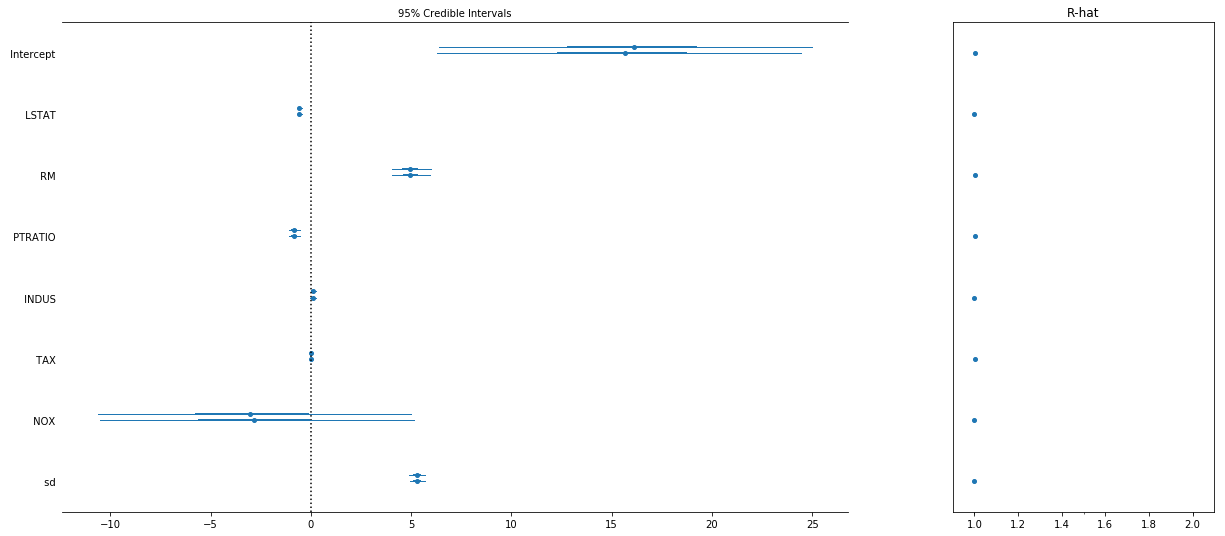

In [17]:
# Forest plot
plt.figure(figsize=(20, 8))
pm.forestplot(normal_trace)

From the forest plot, we can see the most likely value of the parameter (the dot) as well as the 95% credible interval for the parameter. The `intercept` and `NOX` have larger uncertainity compared to the other variables.

Another built-in plotting method in PyMC3 is the posterior distribution of all the model parameters. These histograms allow us to see how  the model result is a distribution of the parameters rather than a single value.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5b82a3dc18>,
      dtype=object)

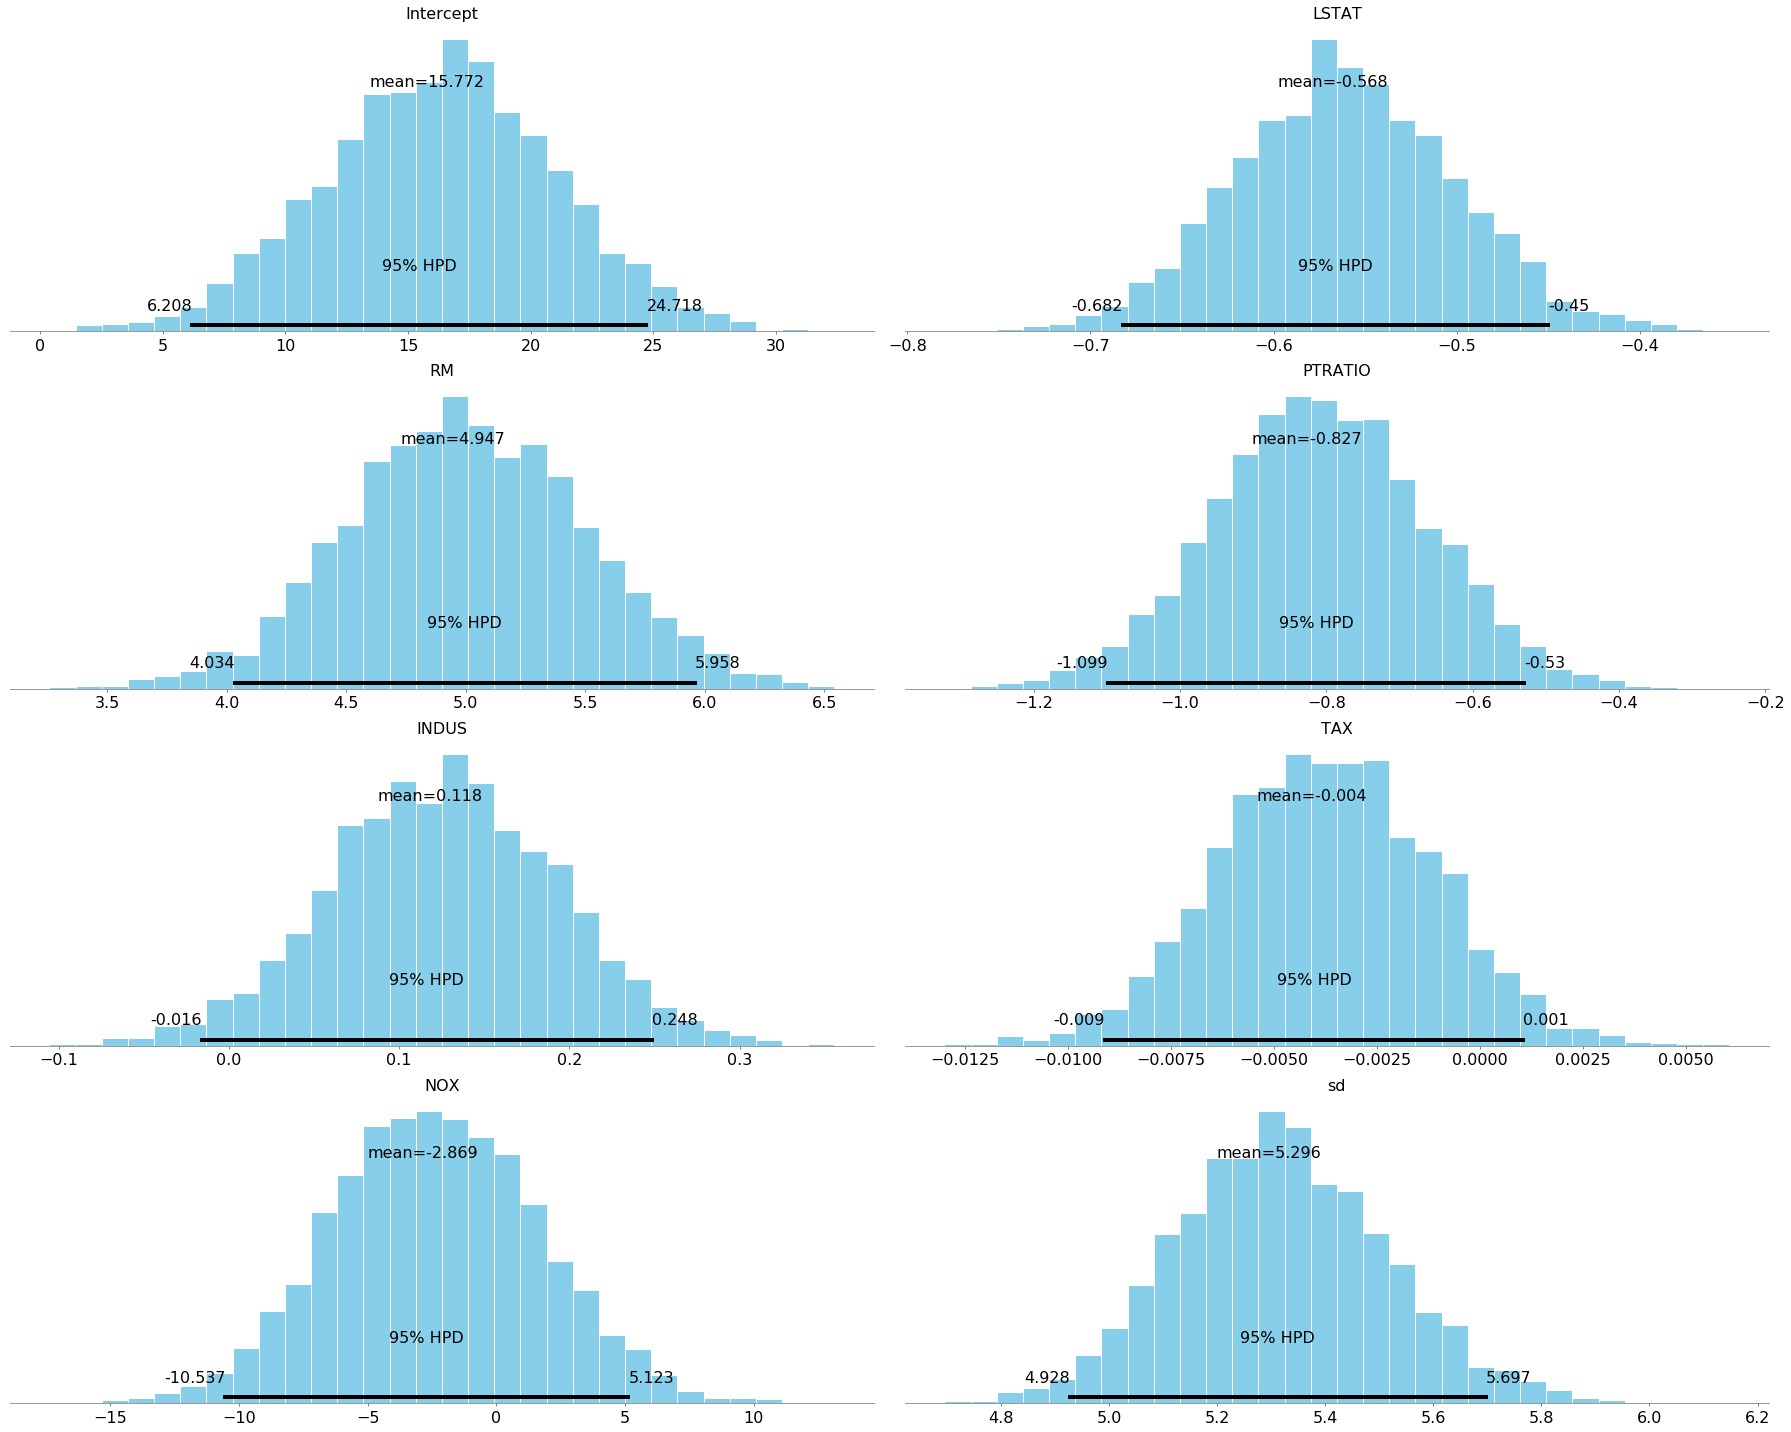

In [18]:
# Posterior distribution
pm.plot_posterior(normal_trace, figsize=(25, 20), text_size=16)

In [19]:
#  Print out the mean variable weight from the trace
for variable in normal_trace.varnames:
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, np.mean(normal_trace[variable])))

Variable: Intercept       Mean weight in model: 15.7723
Variable: LSTAT           Mean weight in model: -0.5679
Variable: RM              Mean weight in model: 4.9473
Variable: PTRATIO         Mean weight in model: -0.8266
Variable: INDUS           Mean weight in model: 0.1182
Variable: TAX             Mean weight in model: -0.0041
Variable: NOX             Mean weight in model: -2.8694
Variable: sd_log__        Mean weight in model: 1.6662
Variable: sd              Mean weight in model: 5.2956


#### Interpretations of Weights

Based on the sign and location of weights, we can make the following inferences regarding the features in the data:

>- Previous LSTAT values are negatively related to MEDV.
>- Higher RM is positively related to MDEV.
>- TAX and NOX are negatively related to MEDV.

In [20]:
pm.trace_to_dataframe(normal_trace).describe().T

count       mean       std        min        25%        50%  \
Intercept  4000.0  15.772346  4.740546  -0.141512  12.612718  15.920546   
LSTAT      4000.0  -0.567903  0.060282  -0.786900  -0.608858  -0.569210   
RM         4000.0   4.947317  0.497704   3.204516   4.607250   4.939436   
PTRATIO    4000.0  -0.826632  0.146224  -1.340069  -0.924568  -0.828500   
INDUS      4000.0   0.118240  0.067340  -0.113065   0.072319   0.118961   
TAX        4000.0  -0.004083  0.002638  -0.013315  -0.005902  -0.004082   
NOX        4000.0  -2.869445  4.047649 -17.877284  -5.638298  -2.931639   
sd         4000.0   5.295588  0.196431   4.671288   5.159951   5.290022   

                 75%        max  
Intercept  18.959190  31.840624  
LSTAT      -0.527365  -0.358203  
RM          5.285481   6.486910  
PTRATIO    -0.729665  -0.267109  
INDUS       0.164633   0.347838  
TAX        -0.002299   0.005730  
NOX        -0.118201  12.618845  
sd          5.425087   6.123578

In [21]:
# Linear formula from Bayesian inference
model_formula = 'MEDV = '
for variable in normal_trace.varnames:
    model_formula += ' %.2f * %s +' % (np.mean(normal_trace[variable]), variable)
' '.join(model_formula.split(' ')[:-1])

'MEDV =  15.77 * Intercept + -0.57 * LSTAT + 4.95 * RM + -0.83 * PTRATIO + 0.12 * INDUS + -0.00 * TAX + -2.87 * NOX + 1.67 * sd_log__ + 5.30 * sd'

#### Evaluate Bayesian Model Using Mean of Model Parameters

#### Make Observations

In [22]:
# Predictions from the test set and compare to actual values
def test_model(trace, test_observation):
    '''Make a new prediction from the test set and compare to actual value.'''
    # Print out the test observation data
    print('Test observation:')
    print(f'{test_observation}\n')
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Standard deviation of the likelihood
    sd_value = var_weights['sd'].mean()
    
    # Actual Value
    actual = test_observation['MEDV']
    
    # Add in intercept term
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('MEDV')
    
    # Align weights and test observation
    var_weights = var_weights[test_observation.index]
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Location of mean for observation
    mean_loc = np.dot(var_means, test_observation)
    
    # Estimates
    estimates = np.random.normal(loc=mean_loc,
                                 scale=sd_value,
                                 size=1000)
    
    # Plot estimates
    plt.figure(figsize=(8, 8))
    sns.distplot(estimates,
                 hist=True,
                 kde=True,
                 bins=19,
                 hist_kws={'edgecolor': 'k', 'color': 'darkblue'},
                 kde_kws={'linewidth': 4},
                 label='Estimated Distribution')
    # Plot actuals
    plt.vlines(x=actual,
               ymin=0,
               ymax=.1,
               linestyles='--',
               colors='red',
               label='True MEDV',
               linewidth=2.5)
    # Plot mean estimate
    plt.vlines(x=mean_loc,
               ymin=0,
               ymax=.1,
               linestyles='-',
               colors='orange',
               label='Mean Estimate',
               linewidth=2.5)
    plt.legend(loc=1)
    plt.title('Density Plot for Test Observation')
    plt.xlabel('MEDV')
    plt.ylabel('Density')
    
    # Prediction information
    print(f'True MEDV = {round(actual, 4)}')
    print(f'Average Estimate = {round(mean_loc, 4)}')
    print(f'5% Estimate = {round(np.percentile(estimates, 5), 4)}\n' +
          f'95% Estimate = {round(np.percentile(estimates, 95), 4)}')

Test observation:
MEDV        28.200
LSTAT        7.530
RM           6.849
PTRATIO     18.400
INDUS        2.180
TAX        222.000
NOX          0.472
Name: 307, dtype: float64

True MEDV = 28.2
Average Estimate = 28.1672
5% Estimate = 19.7459
95% Estimate = 37.2283


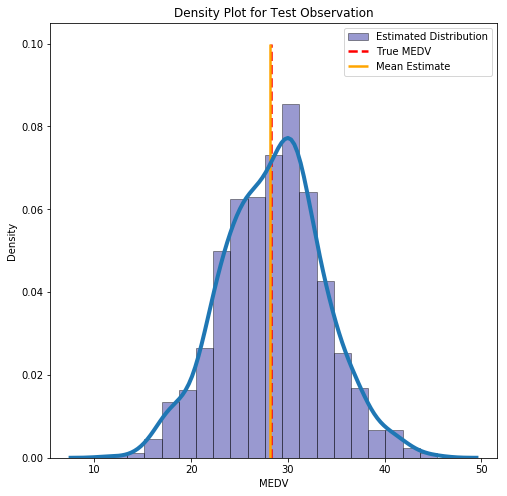

In [23]:
test_model(normal_trace, X_test.iloc[41])

Test observation:
MEDV        18.800
LSTAT       17.580
RM           5.879
PTRATIO     19.100
INDUS       25.650
TAX        188.000
NOX          0.581
Name: 124, dtype: float64

True MEDV = 18.8
Average Estimate = 19.6833
5% Estimate = 10.8938
95% Estimate = 28.3322


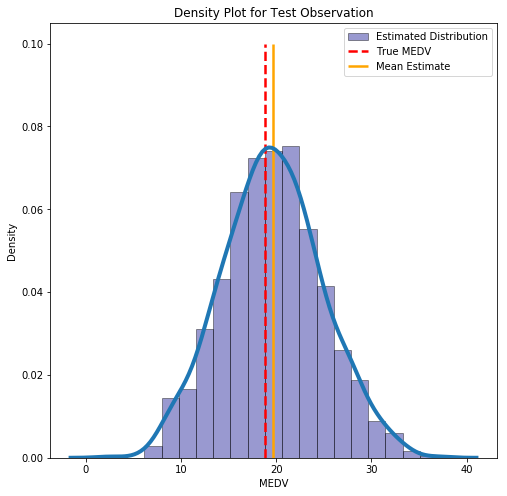

In [24]:
test_model(normal_trace, X_test.iloc[16])

#### Predictions for New Observation

In [25]:
# Make predictions for a new data point
def query_model(trace, new_observation):
    '''Make predictions for a new data point from the model trace.'''
    # Print information about the new observation
    print('New Observation')
    print(f'{new_observation}\n')
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Standard deviation
    sd_value = var_dict['sd'].mean()
    
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Align weights into a dataframe
    var_weights = var_weights[new_observation.index]
    
    # Means of variables
    var_means = var_weights.mean(axis=0)
    
    # Mean of observation
    mean_loc = np.dot(var_means, new_observation)
    
    # Distribution of estimates
    estimates = np.random.normal(loc=mean_loc,
                                 scale=sd_value,
                                 size=1000)
    
    # Plot estimates distribution
    plt.figure(figsize=(8, 8))
    sns.distplot(estimates,
                 hist=True,
                 kde=True,
                 bins=19,
                 hist_kws={'edgecolor': 'k', 'color': 'darkblue'},
                 kde_kws={'linewidth': 4},
                 label='Estimated Distribution')
    # Plot mean estimate
    plt.vlines(x=mean_loc,
               ymin=0,
               ymax=.1,
               linestyles='-',
               colors='orange',
               linewidth=2.5)
    plt.title('Density Plot for New Observation')
    plt.xlabel('MEDV')
    plt.ylabel('Density')
    
    # Estimate information
    print(f'Average Estimate = {round(mean_loc, 4)}')
    print(f'5% Estimate = {round(np.percentile(estimates, 5), 4)}\n' +
          f'95% Estimate = {round(np.percentile(estimates, 95), 4)}')

New Observation
Intercept    1.0
LSTAT        4.0
RM           0.0
PTRATIO      1.0
INDUS        3.0
TAX          1.0
NOX          1.0
dtype: float64

Average Estimate = 10.1553
5% Estimate = 1.5411
95% Estimate = 18.93


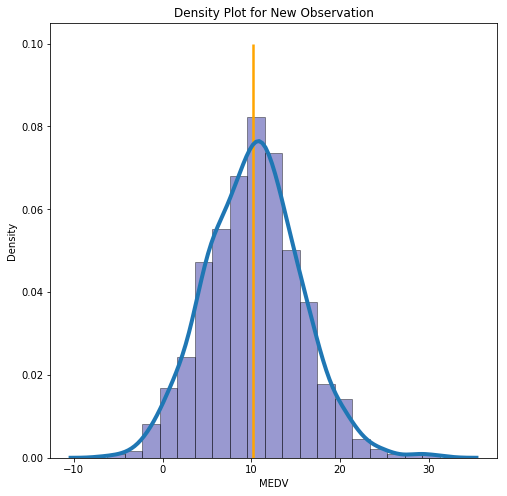

In [26]:
observation = pd.Series({'Intercept': 1, 'LSTAT': 4,
                         'RM': 0., 'PTRATIO': 1,
                         'INDUS': 3, 'TAX': 1,
                         'NOX': 1})
query_model(normal_trace, observation)

New Observation
Intercept     1.0
LSTAT        40.0
RM           10.0
PTRATIO      12.0
INDUS        34.0
TAX          21.0
NOX          11.0
dtype: float64

Average Estimate = 4.9803
5% Estimate = -3.4815
95% Estimate = 14.1818


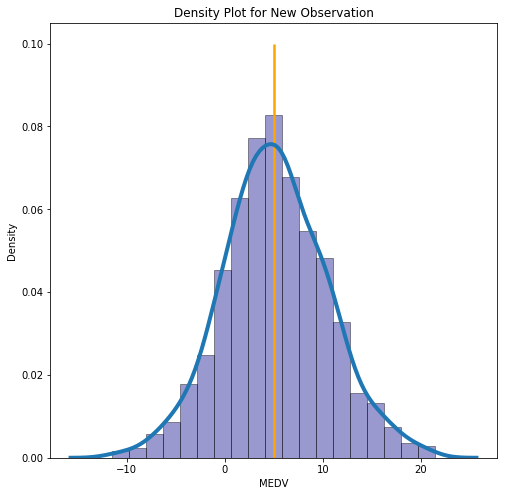

In [27]:
observation = pd.Series({'Intercept': 1., 'LSTAT': 40.,
                         'RM': 10., 'PTRATIO': 12.,
                         'INDUS': 34., 'TAX': 21.,
                         'NOX': 11.})
query_model(normal_trace, observation)